# Final project - FDS
The first code block retrives the images, and then does the preprocessing stages of converting to grayscale, making shure all the images are the same size and normalizes the grayscale values. 

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Function to collect all images from a folder (including subfolders)
def collect_images_from_folder(folder_path):
    image_paths = []
    # Walk through all subfolders and gather image file paths
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            image_paths.append(os.path.join(root, file))
    return image_paths

# Function to preprocess the images (resize, grayscale, and normalize)
def preprocess_images(image_paths, image_size=(128, 128)):
    processed_images = []
    for img_path in image_paths:
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img_resized = img.resize(image_size)  # Resize
        img_array = np.array(img_resized) / 255.0  # Normalize to [0, 1]
        processed_images.append(img_array)
    return np.array(processed_images)

# Extracting all the lables from the dataset
def extract_labels(image_paths):
    """Extracts labels from the parent folder names."""
    labels = []
    for path in image_paths:
        label = os.path.basename(os.path.dirname(path))
        labels.append(label)
    return np.array(labels)

# Collect all image paths
train_folder = "intel-image-classification/seg_train"
test_folder  = "intel-image-classification/seg_test"
pred_folder  = "intel-image-classification/seg_pred"   # not used until prediction phase

train_paths = collect_images_from_folder(train_folder)
test_paths  = collect_images_from_folder(test_folder)

print("Train samples:", len(train_paths))
print("Test samples:", len(test_paths))

# Extract lables
y_train = extract_labels(train_paths)
y_test  = extract_labels(test_paths)

print("Train labels:", np.unique(y_train))
print("Test labels:", np.unique(y_test))

#Preprocessing the images
X_train = preprocess_images(train_paths)
X_test  = preprocess_images(test_paths)

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Train samples: 14034
Test samples: 3000
Train labels: ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
Test labels: ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
Train data shape: (14034, 128, 128)
Test data shape: (3000, 128, 128)


### Displaying the different images preprocessed:

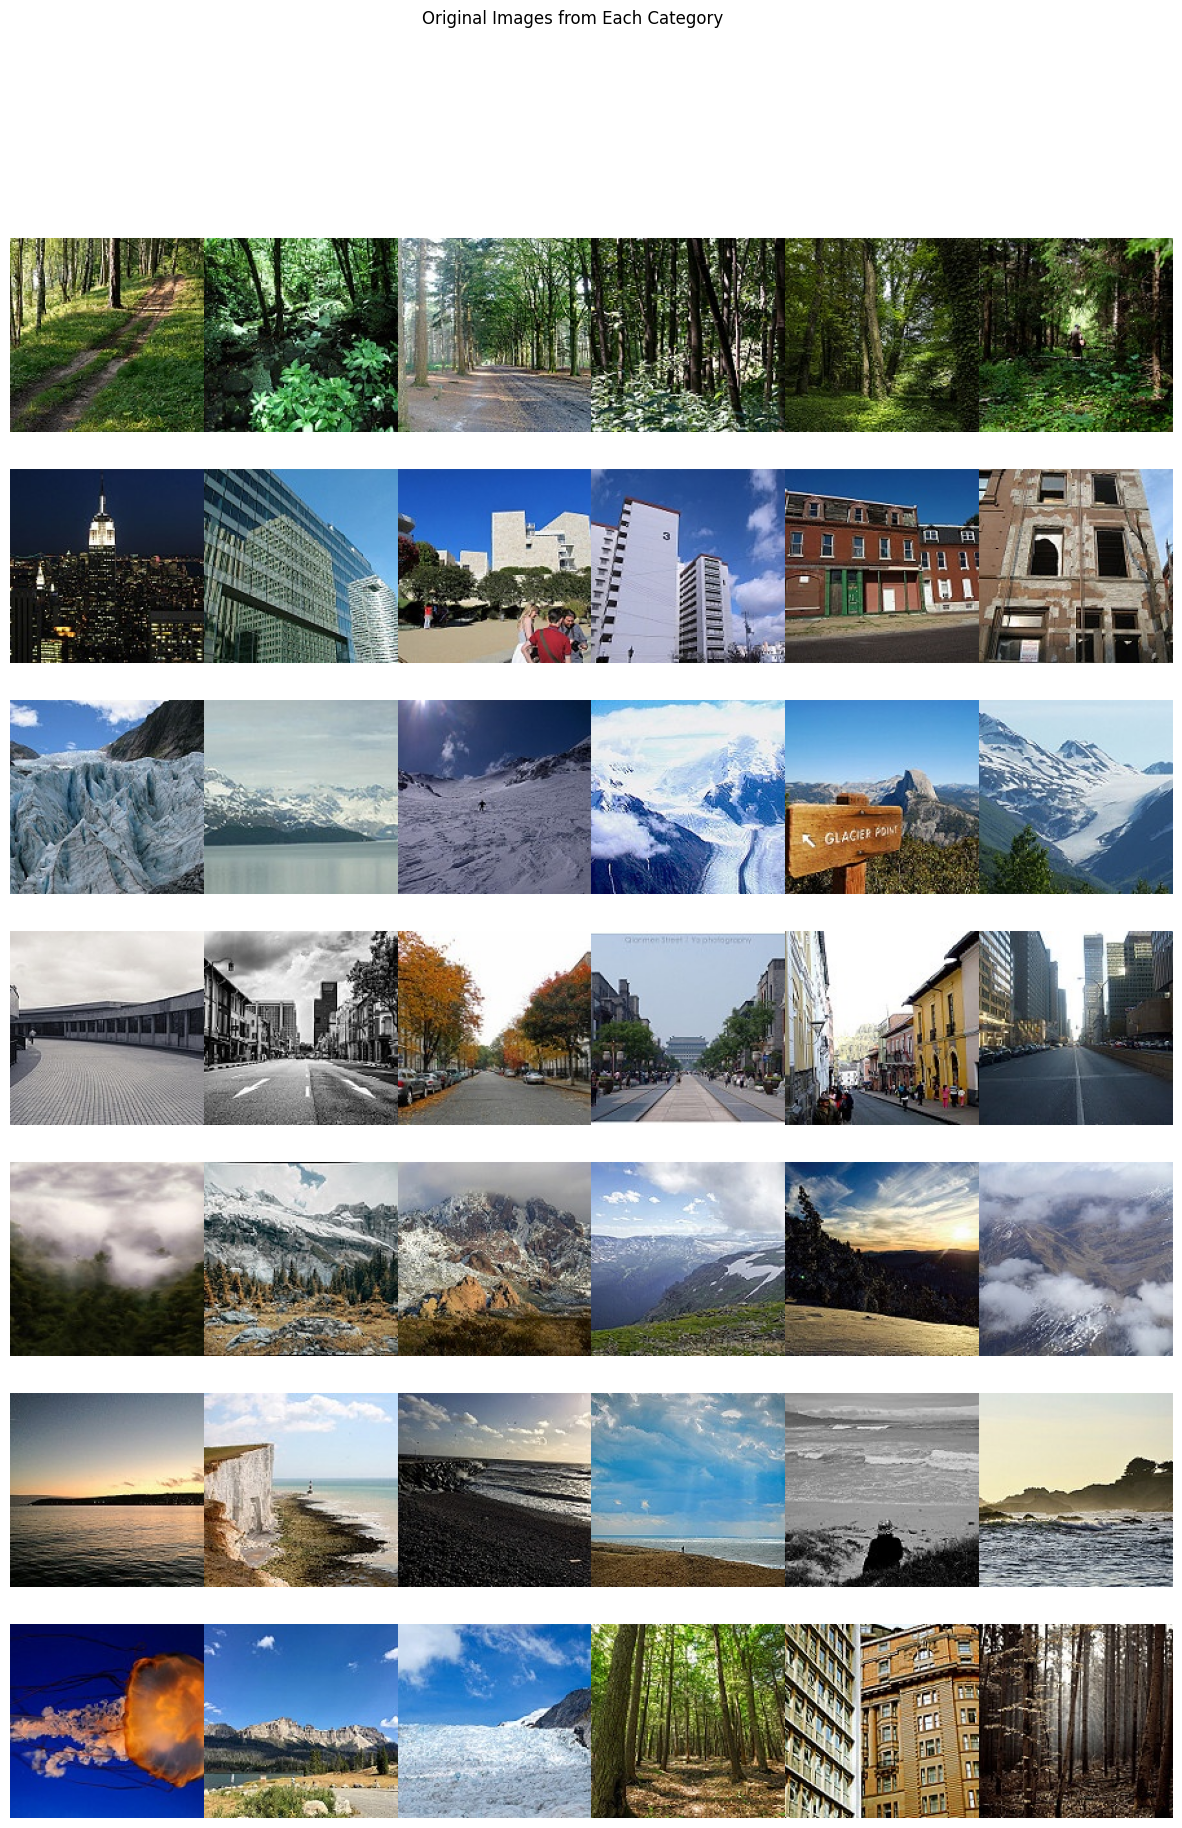

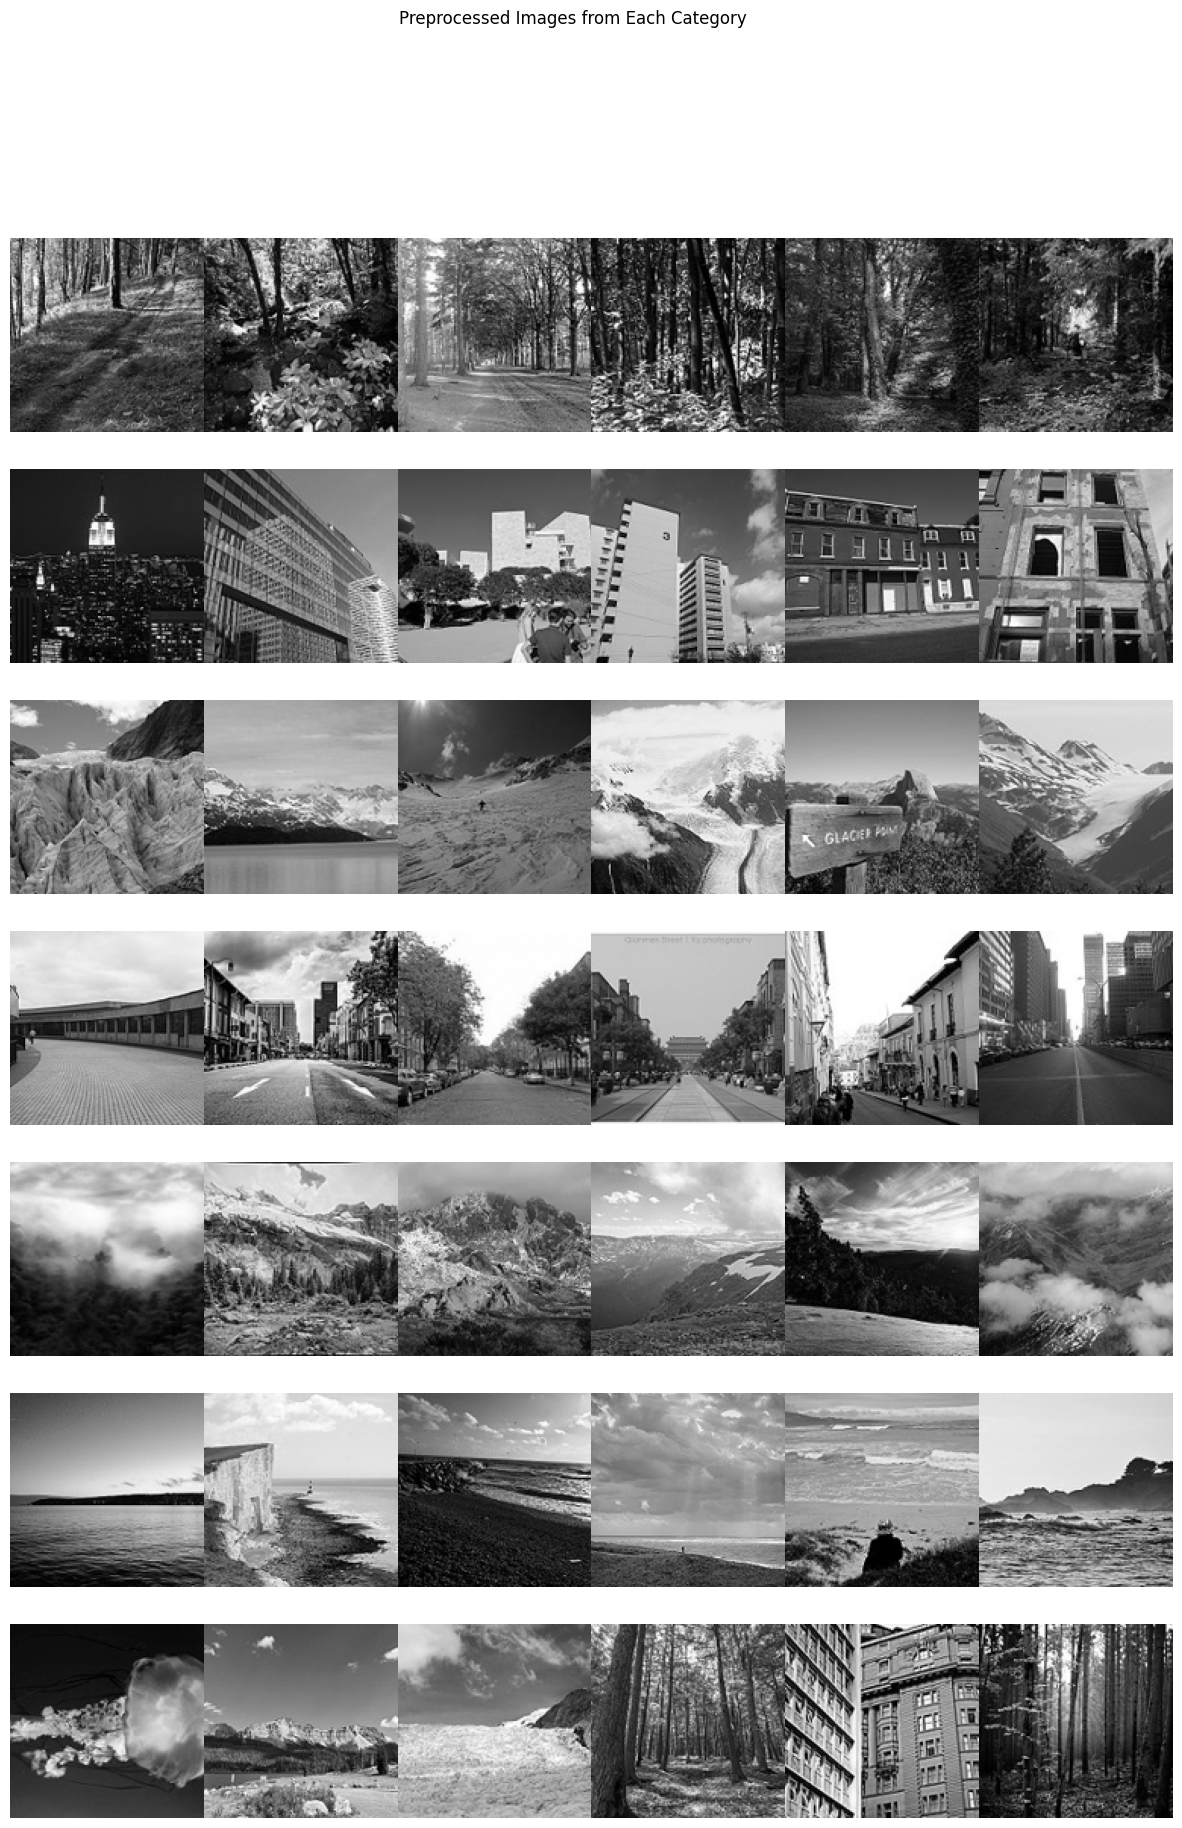

In [8]:
from collections import defaultdict

# Function to collect images from each category folder (6 images per category)
def collect_images_from_categories(folder_path, images_per_category=6):
    category_images = defaultdict(list)
    # Walk through subfolders and collect images by category
    for root, dirs, files in os.walk(folder_path):
        category = os.path.basename(root)  # Use subfolder name as category
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                if len(category_images[category]) < images_per_category:
                    category_images[category].append(os.path.join(root, file))
    return category_images

category_images = collect_images_from_categories(folder_path)

images_per_category = 6
num_categories = len(category_images)

fig, axs = plt.subplots(
    num_categories, 
    images_per_category,
    figsize=(15, 3 * num_categories),
    gridspec_kw={'wspace': 0, 'hspace': 0}
)

for i, (category, images) in enumerate(category_images.items()):
    for j in range(images_per_category):
        axs[i][j].axis('off')
        if j < len(images):
            img = Image.open(images[j])
            axs[i][j].imshow(img)
            
plt.suptitle("Original Images from Each Category")
plt.show()

fig, axs = plt.subplots(
    num_categories, 
    images_per_category,
    figsize=(15, 3 * num_categories),
    gridspec_kw={'wspace': 0, 'hspace': 0}
)

for i, (category, images) in enumerate(category_images.items()):
    processed_images = preprocess_images(images[:images_per_category])
    
    for j in range(images_per_category):
        axs[i][j].axis('off')
        if j < len(processed_images):
            axs[i][j].imshow(processed_images[j], cmap='gray')

plt.suptitle("Preprocessed Images from Each Category")
plt.show()

### Feature extraction

Since the data we are using has a high dimentionality due to beeing images we decided to use PCA to reduce the number of dimentions. 

Computing FAST PCA with max 300 components...
Components needed for 80% variance: 169
Variance retained: 0.8002


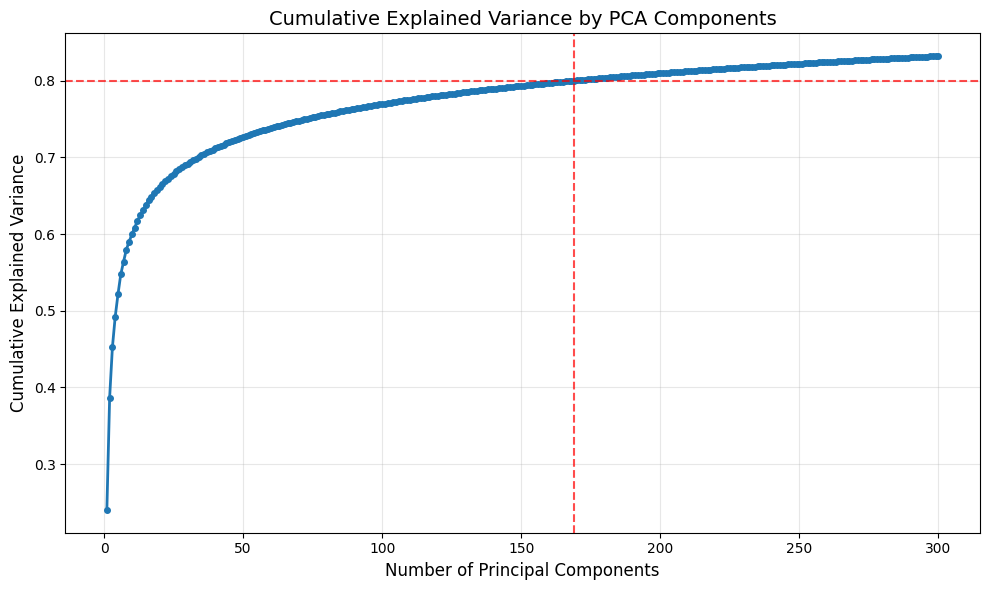

Train PCA shape: (14034, 169)
Test PCA shape: (3000, 169)


In [6]:
from sklearn.decomposition import PCA

# flatten features
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

n_samples, n_features = X_train_flat.shape

# limit PCA to at most 300 components for speed
MAX_COMPONENTS = min(300, n_samples, n_features)

print(f"Computing FAST PCA with max {MAX_COMPONENTS} components...")

# very fast and scalable PCA (randomized SVD)
pca_fast = PCA(
    n_components=MAX_COMPONENTS,
    svd_solver="randomized",
    random_state=42
)

pca_fast.fit(X_train_flat)

# cumulative explained variance
cumulative_var = np.cumsum(pca_fast.explained_variance_ratio_)

# number of components needed for 80% variance
n_components_80 = np.argmax(cumulative_var >= 0.80) + 1
print(f"Components needed for 80% variance: {n_components_80}")
print(f"Variance retained: {cumulative_var[n_components_80 - 1]:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_var) + 1),
         cumulative_var, 
         'o-', linewidth=2, markersize=4)

plt.axhline(y=0.80, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
plt.axvline(x=n_components_80, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Explained Variance by PCA Components', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# final PCA model using only the required components
pca = PCA(
    n_components=n_components_80,
    svd_solver="randomized",
    random_state=42
)
pca.fit(X_train_flat)

# Transform sets
X_train_pca = pca.transform(X_train_flat)
X_test_pca  = pca.transform(X_test_flat)

print("Train PCA shape:", X_train_pca.shape)
print("Test PCA shape:", X_test_pca.shape)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import numpy as np

# Train the random forest classifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf.fit(X_train_pca, y_train)

# Evaluate the model 

y_pred = rf.predict(X_test_pca)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Train the SVM and compare with random forest

from sklearn.svm import SVC

svm = SVC(
    kernel='rbf',
    C=5,
    gamma='scale'
)

print("Training SVM...")
svm.fit(X_train_pca, y_train)

#Evaluate the model

y_pred = svm.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Training Random Forest...

Accuracy: 0.5343333333333333

Classification Report:
              precision    recall  f1-score   support

   buildings       0.49      0.43      0.46       437
      forest       0.57      0.71      0.63       474
     glacier       0.46      0.58      0.51       553
    mountain       0.60      0.59      0.59       525
         sea       0.57      0.33      0.41       510
      street       0.55      0.55      0.55       501

    accuracy                           0.53      3000
   macro avg       0.54      0.53      0.53      3000
weighted avg       0.54      0.53      0.53      3000

Training SVM...
Accuracy: 0.5623333333333334
              precision    recall  f1-score   support

   buildings       0.52      0.47      0.49       437
      forest       0.63      0.75      0.69       474
     glacier       0.53      0.53      0.53       553
    mountain       0.56      0.61      0.59       525
         sea       0.49      0.43      0.45       510
      s